In [ ]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from patsy import dmatrix

import causalpy as cp

## The Pardox of Propensity Scores in Bayesian Inference

In causal inference the role of the propensity score is often seen to be central. We've seen how the propensity score can be used with the `cp.InversePropensityWeighting` class to correct for a species of selection bias by re-weighting our outcome variable and calculating a causal contrast on the re-weighted scale. Additionally we can use the propensity score to visualise and diagnose problems of overlap or covariate balancing across treatment and control groups. 

These properties give the propensity score a large role to play in _design based_ approaches to causal inference. The focus is on assessing aspects of the treatment allocation to ensure we have identifiability assurances for estimands of interest. 

When we use `cp.InversePropensityWeighting` to apply various re-weighting techniques we perform a two-step  manoeuvre: (1) we estimate the propensity score and (2) apply the inverse-weighting of the score to transform our outcome variable and assess causal contrasts. But being good Bayesians, we might wonder why go to all this trouble? Can we not simple estimate a full-bayesian model of treatment and outcome simultaneously?

In this notebook we'll show why we should be careful attempting to model the joint-distribution of the propensity score and the outcome variable, but still make good use of the propensity score. 

### Brief Digression on the Mathematics

Consider that we have the following three variables:

$$ P(Y, T, X) $$ 

where $Y$ is our outcome variable, $T$ is our treatment variable, and $X$ stands in for all other control variables in scope. Now define the propensity score

$$ e(X) = P(T | X)$$

and our outcome model

$$ P(Y | T, X) = \dfrac{P(Y, T, X)}{P(T, X)}\cdot P(T, X) = \dfrac{P(Y | T, X) \cdot P(T | X) \cdot P(X)}{P(T | X) \cdot P(X)} P(T, X) = \dfrac{P(Y | T, X) \cdot e(X)\cdot P(X)}{e(X) \cdot P(X)} \cdot P(T, X) $$

but now it's clearer to see how the propensity score just cancels out. When we're already conditioning on $X, T$ the information in the propensity score is technically redundant in the Bayesian setting. Add the assumption of unconfoundedness or ignorability used in causal inference. We are arguing that there is no umeasured confounding so conditioning on $X, T$ should be sufficient to identify the causal contrast of interest. 

### Structure of the Presentation

We will first consider a simple simulated data set where we know the true values of the data generating process. We'll first demonstrate how to fit the joint distribution of the propensity score and the outcome in a single joint distribution using `PyMC`. Then we'll show how to fit a two-stage version of the same model. In both models we assume independent priors between the regression for the treatment and the regression for the outcome variable. Nevertheless, we will show that the joint model exhibits a bias due to feedback when there is non-measured confounding i.e. when there is misspecified outcome model. 

- Model Specification
    - Joint Model
    - 2 Stage Model
- Application to Simulated Outcome
- Application to Mosquito Net Data
- Application to Lalonde Data
- Application to NHEFS data.

Note the presentation here owes a debt to the work of Fan Li in {cite:p}`liBayesianProp` and her presentation [here](https://youtu.be/_BjkF2nl7dg?si=Pmza3EoTpz-flT8m&t=26). Additionally we drew on the work and data of Andrew Heiss [here](https://www.andrewheiss.com/blog/2021/12/18/bayesian-propensity-scores-weights/) and Jordan Nafa and Andrew Heiss [here](https://www.andrewheiss.com/blog/2021/12/20/fully-bayesian-ate-iptw/). 

#### Generate Some Data

In [ ]:
N = 1000


df1 = pd.DataFrame(
    np.random.multivariate_normal([0.5, 1], [[2, 1], [1, 1]], size=N),
    columns=["x1", "x2"],
)
df1["trt"] = np.where(
    -0.5 + 0.25 * df1["x1"] + 0.75 * df1["x2"] + np.random.normal(0, 1, size=N) > 0,
    1,
    0,
)
TREATMENT_EFFECT = 2
df1["outcome"] = (
    4
    + TREATMENT_EFFECT * df1["trt"]
    + df1["x1"]
    + df1["x2"]
    + np.random.normal(0, 1, size=N)
)
df1.head()

,x1,x2,trt,outcome
0,2.238452,2.060227,1,10.022882
1,0.739961,0.926924,0,4.978688
2,1.191126,-0.532201,0,4.805062
3,-1.487591,0.373743,0,1.449932
4,-0.256297,1.680710,1,9.100173


### Specifying the Joint Model

Here we will define a model context that fits our data simultaneously for treatment and outcome. We allow that the propensity score estimated in the treatment model is used in a non-parametric spline to flexibly inform the outcome variable

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


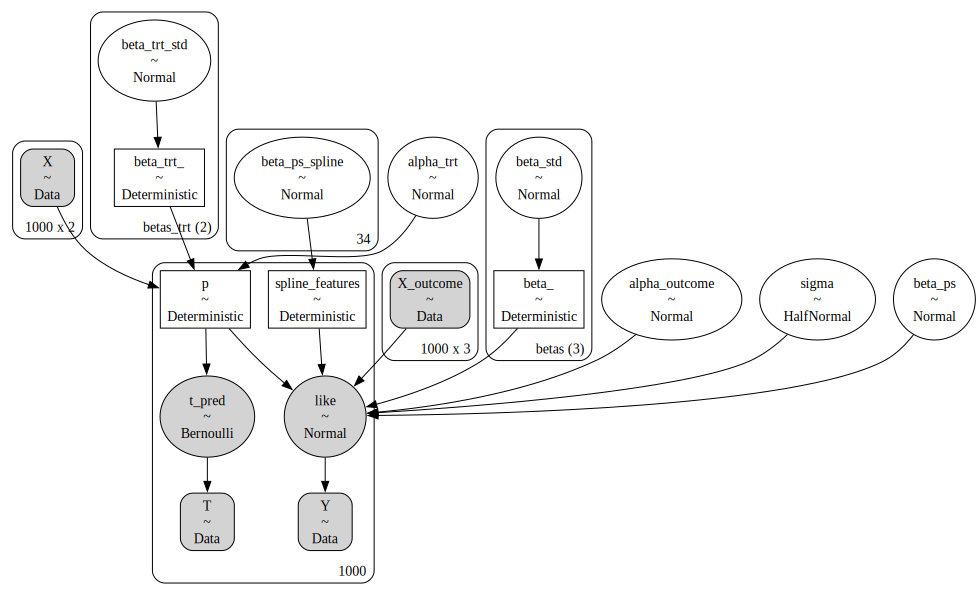

In [373]:
coords = {
    "betas": ["trt", "x1", "x2"],
    "betas_trt": ["x1", "x2"],
    "obs": range(df1.shape[0]),
}

N = df1.shape[0]
X_trt = df1[["x1", "x2"]].values
X_outcome = df1[["trt", "x1", "x2"]].values
T_data = df1["trt"].values
Y_data = df1["outcome"].values


def make_model(
    X_trt,
    X_outcome,
    T_data,
    Y_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
    },
    noncentred=True,
):
    with pm.Model(coords=coords) as model:
        X_data_trt = pm.Data("X", X_trt)
        X_data_outcome = pm.Data("X_outcome", X_outcome)
        T_data_ = pm.Data("T", T_data, mutable=True)
        Y_data_ = pm.Data("Y", Y_data)

        if noncentred:
            mu_beta_trt, sigma_beta_trt = priors["beta_trt"]
            beta_trt_std = pm.Normal("beta_trt_std", 0, 1, dims="betas_trt")
            beta_trt = pm.Deterministic(
                "beta_trt_",
                mu_beta_trt + sigma_beta_trt * beta_trt_std,
                dims="betas_trt",
            )

            mu_beta, sigma_beta = priors["beta_"]
            beta_std = pm.Normal("beta_std", 0, 1, dims="betas")
            beta = pm.Deterministic(
                "beta_", mu_beta + sigma_beta * beta_std, dims="betas"
            )
        else:
            beta_trt = pm.Normal(
                "beta_trt_",
                priors["beta_trt"][0],
                priors["beta_trt"][1],
                dims="betas_trt",
            )

            beta = pm.Normal(
                "beta_", priors["beta_"][0], priors["beta_"][1], dims="betas"
            )

        beta_ps_spline = pm.Normal("beta_ps_spline", 0, 1, size=34)
        beta_ps = pm.Normal("beta_ps", 0, 1)

        alpha_trt = pm.Normal(
            "alpha_trt", priors["alpha_trt"][0], priors["alpha_trt"][1]
        )
        mu_trt = alpha_trt + pm.math.dot(X_data_trt, beta_trt)
        p = pm.Deterministic("p", pm.math.invlogit(mu_trt))

        pm.Bernoulli("t_pred", p=p, observed=T_data_)

        B = dmatrix(
            "bs(ps, knots=knots, degree=3, include_intercept=True) - 1",
            {"ps": np.linspace(0, 1, X_trt.shape[0]), "knots": np.linspace(0, 1, 30)},
        )
        B_f = np.asarray(B, order="F")
        splines_summed = pm.Deterministic(
            "spline_features", pm.math.dot(B_f, beta_ps_spline.T)
        )

        alpha_outcome = pm.Normal(
            "alpha_outcome", priors["alpha_outcome"][0], priors["alpha_outcome"][1]
        )
        mu_outcome = (
            alpha_outcome
            + pm.math.dot(X_data_outcome, beta)
            + p * splines_summed
            + beta_ps * p
        )
        sigma = pm.HalfNormal("sigma", 1)

        _ = pm.Normal("like", mu_outcome, sigma, observed=Y_data_)

    return model


model = make_model(X_trt, X_outcome, T_data, Y_data, coords)

pm.model_to_graphviz(model)

Note how the two likelihood terms are fit simultaneously. 

### Specifying the 2 Stage Model

Here we allow for a function that takes the same inputs but fits two separate models. First we fit the treatment model then store the `idata_treatment` this xarray object stores the posterior estimates for the propensity score. We pass this through to a second outcome model where we proceed to take a random draw from the posterior and pass it through to the outcome regression via a spline component. This allows us to express any non-linearity in the treatment effect. Additionally it can be seen as a way to augment the outcome model.

While theoretically the propensity score contains no extra information if we are already conditioning on $X$, practically the literature reports that the propensity improves the stability of the causal estimates achievable in Bayesian causal modelling. 

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


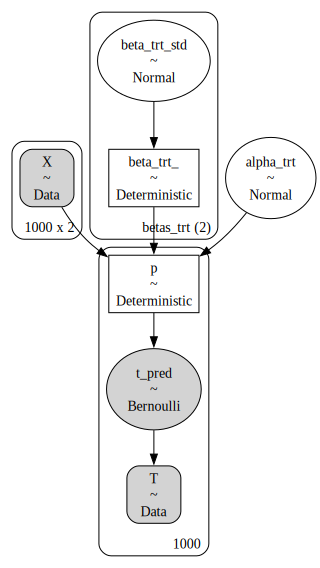

In [375]:
def make_treatment_model(
    X_trt,
    T_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
    },
    noncentred=True,
):
    with pm.Model(coords=coords) as model_trt:
        X_data_trt = pm.Data("X", X_trt)
        T_data_ = pm.Data("T", T_data, mutable=True)

        if noncentred:
            mu_beta_trt, sigma_beta_trt = priors["beta_trt"]
            beta_trt_std = pm.Normal("beta_trt_std", 0, 1, dims="betas_trt")
            beta_trt = pm.Deterministic(
                "beta_trt_",
                mu_beta_trt + sigma_beta_trt * beta_trt_std,
                dims="betas_trt",
            )

        else:
            beta_trt = pm.Normal(
                "beta_trt_",
                priors["beta_trt"][0],
                priors["beta_trt"][1],
                dims="betas_trt",
            )

        alpha_trt = pm.Normal(
            "alpha_trt", priors["alpha_trt"][0], priors["alpha_trt"][1]
        )
        mu_trt = alpha_trt + pm.math.dot(X_data_trt, beta_trt)
        p = pm.Deterministic("p", pm.math.invlogit(mu_trt))

        pm.Bernoulli("t_pred", p=p, observed=T_data_)
    return model_trt


def make_outcome_model(
    X_outcome,
    Y_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
    },
    noncentred=True,
    propensity_score_idata=None,
):
    propensity_scores = az.extract(propensity_score_idata)["p"]
    with pm.Model(coords=coords) as model_outcome:
        X_data_outcome = pm.Data("X_outcome", X_outcome)
        Y_data_ = pm.Data("Y", Y_data)

        if noncentred:
            mu_beta, sigma_beta = priors["beta_"]
            beta_std = pm.Normal("beta_std", 0, 1, dims="betas")
            beta = pm.Deterministic(
                "beta_", mu_beta + sigma_beta * beta_std, dims="betas"
            )
        else:
            beta = pm.Normal(
                "beta_", priors["beta_"][0], priors["beta_"][1], dims="betas"
            )

        beta_ps_spline = pm.Normal("beta_ps_spline", 0, 1, size=34)

        chosen = np.random.choice(range(propensity_scores.shape[1]))
        p = propensity_scores[:, chosen].values

        B = dmatrix(
            "bs(ps, knots=knots, degree=3, include_intercept=True, lower_bound=0, upper_bound=1) - 1",
            {"ps": p, "knots": np.linspace(0, 1, 30)},
        )
        B_f = np.asarray(B, order="F")
        splines_summed = pm.Deterministic(
            "spline_features", pm.math.dot(B_f, beta_ps_spline.T)
        )

        alpha_outcome = pm.Normal(
            "alpha_outcome", priors["alpha_outcome"][0], priors["alpha_outcome"][1]
        )
        mu_outcome = alpha_outcome + pm.math.dot(X_data_outcome, beta) + splines_summed
        sigma = pm.HalfNormal("sigma", 1)

        _ = pm.Normal("like", mu_outcome, sigma, observed=Y_data_)

    return model_outcome


def make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors):
    treatment_model = make_treatment_model(X_trt, T_data, coords, priors)
    with treatment_model:
        idata_treatment = pm.sample_prior_predictive()
        idata_treatment.extend(pm.sample())

    outcome_model = make_outcome_model(
        X_outcome, Y_data, coords, priors, propensity_score_idata=idata_treatment
    )
    with outcome_model:
        idata_outcome = pm.sample_prior_predictive()
        idata_outcome.extend(pm.sample())

    return idata_treatment, idata_outcome, treatment_model, outcome_model


model_treatment = make_treatment_model(X_trt, T_data, coords)

pm.model_to_graphviz(model_treatment)

### Putting it all Together

In [378]:
priors = {
    "beta_": [0, 1],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [0, 1],
}

joint_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

with joint_model:
    idata_joint = pm.sample(tune=2000, target_accept=0.98)

(
    idata_treatment_2s_joint,
    idata_outcome_2s_joint,
    treatment_model_joint,
    outcome_model_joint,
) = make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors)

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps_spline, beta_ps, alpha_trt, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 44 seconds.
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [alpha_outcome, beta_ps_spline, beta_std, like, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps_spline, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


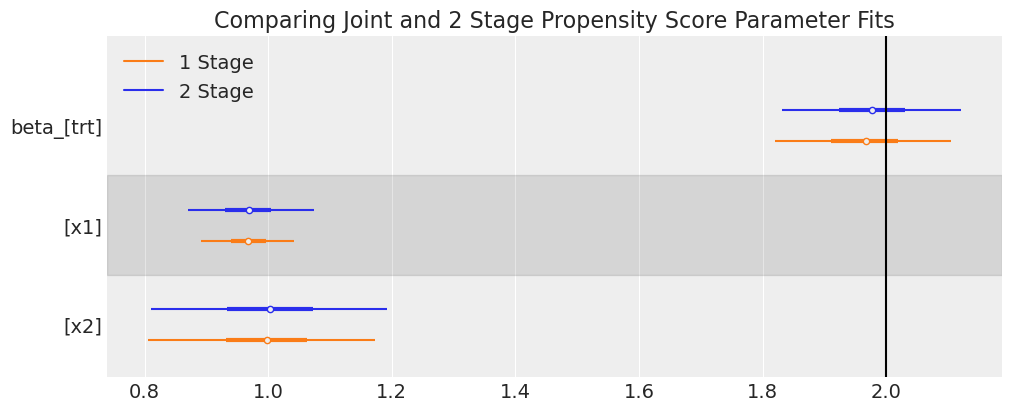

In [387]:
ax = az.plot_forest(
    [idata_outcome_2s_joint, idata_joint],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].axvline(2, label="True Treatment Value", color="k")
ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

In [389]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_joint, var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_joint, var_names=["beta_", "alpha_outcome"]
        ),
    }
)
compare_estimate

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1-stage-model alpha_trt     -0.840  0.121  -1.072   -0.618      0.002   
              beta_[trt]     1.965  0.077   1.820    2.104      0.001   
              beta_[x1]      0.968  0.041   0.891    1.042      0.001   
              beta_[x2]      0.998  0.097   0.805    1.172      0.002   
              beta_ps        0.103  0.444  -0.710    0.936      0.011   
              alpha_outcome  4.021  0.162   3.724    4.331      0.004   
2-stage-model beta_[trt]     1.976  0.078   1.832    2.121      0.001   
              beta_[x1]      0.968  0.054   0.871    1.074      0.001   
              beta_[x2]      1.001  0.103   0.810    1.193      0.002   
              alpha_outcome  3.951  0.200   3.570    4.309      0.006   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
1-stage-model alpha_trt        0.002    2995.0    2858.0    1.0  
              beta_[trt]       0.001    4779.0    3131.0    1.0  
              beta_[x1]        0.001    2562.0    2515.0    1.0  
              beta_[x2]        0.001    2181.0    2465.0    1.0  
              beta_ps          0.008    1669.0    2135.0    1.0  
              alpha_outcome    0.003    1810.0    1882.0    1.0  
2-stage-model beta_[trt]       0.001    5828.0    3089.0    1.0  
              beta_[x1]        0.001    1995.0    2302.0    1.0  
              beta_[x2]        0.002    1870.0    2288.0    1.0  
              alpha_outcome    0.004    1289.0    1966.0    1.0

Here both models seem to recover substantially similar and correct results. This is good to see, but we'll try our hand at some more datasets below where this relationship breaksdown due to the feedback effects within the joint-model specification. 

### Causal Estimate with Do-Operator

We can also confirm the model implications through counterfactual imputation. This ties the Bayesian setting back the potential outcomes framework. The fundamental problem of causal inference, when seen as a missing data problem allows us to derive causal estimands through imputation of the potential outcomes. Here we "push forward" the posterior predictive distribution for $Y$ under different treatment settings. 

In [390]:
X_outcome_trt = X_outcome.copy()
X_outcome_trt[:, 0] = 1

X_outcome_ntrt = X_outcome.copy()
X_outcome_ntrt[:, 0] = 0

In [395]:
with pm.do(
    joint_model,
    {"T": np.ones(len(df1), dtype=np.int32), "X_outcome": X_outcome_trt},
    prune_vars=True,
) as treatment_model:
    idata_trt = pm.sample_posterior_predictive(idata_joint, var_names=["like", "p"])

with pm.do(
    joint_model,
    {"T": np.zeros(len(df1), dtype=np.int32), "X_outcome": X_outcome_ntrt},
    prune_vars=True,
) as ntreatment_model:
    idata_ntrt = pm.sample_posterior_predictive(idata_joint, var_names=["like", "p"])

Sampling: [like]


Output()

Sampling: [like]


Output()

In [396]:
idata_trt["posterior_predictive"]["like"].mean()

<xarray.DataArray 'like' ()> Size: 8B
array(7.45471953)

In [397]:
idata_ntrt["posterior_predictive"]["like"].mean()

<xarray.DataArray 'like' ()> Size: 8B
array(5.49030396)

In [398]:
(
    idata_trt["posterior_predictive"]["like"].mean()
    - idata_ntrt["posterior_predictive"]["like"].mean()
)

<xarray.DataArray 'like' ()> Size: 8B
array(1.96441557)

## Nets Example

Next we'll asses a data set used by Andrew Heiss to demonstrate propensity score methods with `brms`. 

In [399]:
nets_df = pd.read_csv("../../../causalpy/data/nets_df.csv")
nets_df["trt"] = nets_df["net_num"]
nets_df["outcome"] = nets_df["malaria_risk"]
nets_df

,id,net,net_num,malaria_risk,income,health,household,eligible,temperature,resistance,trt,outcome
0,1,True,1,33,781,56,2,False,21.1,59,1,33
1,2,False,0,42,974,57,4,False,26.5,73,0,42
2,3,False,0,80,502,15,3,False,25.6,65,0,80
3,4,True,1,34,671,20,5,True,21.3,46,1,34
4,5,False,0,44,728,17,5,False,19.2,54,0,44
...,...,...,...,...,...,...,...,...,...,...,...,...
1747,1748,True,1,18,961,27,4,False,22.1,27,1,18
1748,1749,False,0,49,906,49,5,False,30.7,55,0,49
1749,1750,False,0,17,1325,92,2,False,21.4,52,0,17
1750,1751,False,0,46,879,33,6,False,27.4,62,0,46


In [400]:
coords = {
    "betas": ["trt", "income", "temperature", "health"],
    "betas_trt": ["income", "temperature", "health"],
    "obs": range(nets_df.shape[0]),
}

# Process and Standardise Inputs
N = nets_df.shape[0]
X_trt = nets_df[["income", "temperature", "health"]].values
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)
X_outcome = nets_df[["trt", "income", "temperature", "health"]].values
X_outcome = (X_outcome - X_outcome.mean(axis=0)) / X_outcome.std(axis=0)
T_data = nets_df["trt"].values
X_outcome[:, 0] = T_data
Y_data = nets_df["outcome"].values

priors = {
    "beta_": [0, 1],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [40, 30],
}
net_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

with net_model:
    idata_net = pm.sample(tune=2000, target_accept=0.98)

idata_treatment_2s_net, idata_outcome_2s_net, treatment_model_net, outcome_model_net = (
    make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)
)

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps_spline, beta_ps, alpha_trt, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 27 seconds.
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [alpha_outcome, beta_ps_spline, beta_std, like, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps_spline, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


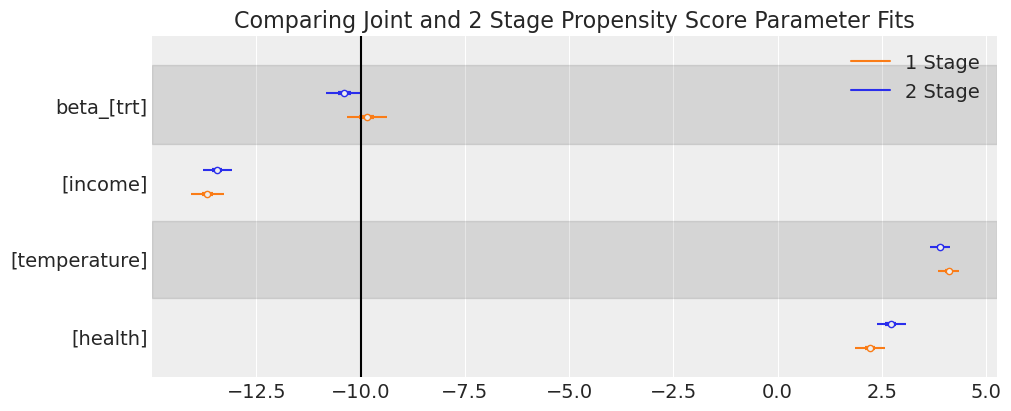

In [403]:
ax = az.plot_forest(
    [idata_outcome_2s_net, idata_net],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].axvline(-10, label="True Treatment Value", color="k")
ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

In [405]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_net, var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_net, var_names=["beta_", "alpha_outcome"]
        ),
    }
)
compare_estimate

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1-stage-model alpha_trt           -0.484  0.051  -0.578   -0.386      0.001   
              beta_[trt]          -9.858  0.255 -10.333   -9.374      0.004   
              beta_[income]      -13.677  0.209 -14.074  -13.284      0.004   
              beta_[temperature]   4.097  0.133   3.851    4.350      0.002   
              beta_[health]        2.215  0.190   1.852    2.564      0.003   
              beta_ps              0.135  1.018  -1.820    2.017      0.021   
              alpha_outcome       39.373  0.427  38.610   40.208      0.009   
2-stage-model beta_[trt]         -10.398  0.229 -10.832   -9.986      0.003   
              beta_[income]      -13.447  0.187 -13.793  -13.095      0.003   
              beta_[temperature]   3.901  0.128   3.646    4.123      0.002   
              beta_[health]        2.703  0.185   2.373    3.080      0.002   
              alpha_outcome       41.255  0.294  40.688   41.772      0.005   

                                  mcse_sd  ess_bulk  ess_tail  r_hat  
1-stage-model alpha_trt             0.000    5896.0    3268.0    1.0  
              beta_[trt]            0.003    5167.0    2725.0    1.0  
              beta_[income]         0.003    2530.0    2940.0    1.0  
              beta_[temperature]    0.001    4341.0    3140.0    1.0  
              beta_[health]         0.002    3623.0    3022.0    1.0  
              beta_ps               0.015    2427.0    2684.0    1.0  
              alpha_outcome         0.006    2200.0    2843.0    1.0  
2-stage-model beta_[trt]            0.002    6723.0    3033.0    1.0  
              beta_[income]         0.002    5272.0    2979.0    1.0  
              beta_[temperature]    0.001    5338.0    3739.0    1.0  
              beta_[health]         0.002    5622.0    2865.0    1.0  
              alpha_outcome         0.004    3495.0    3168.0    1.0

Here again we see broad consistency between both model specifications indicating that the regression adjustment approach in the 2 stage outcome model is appropriate and picks up on all relevant sources of confounding. 

## LaLonde Example

The Lalonde Data set is famous because it highlights a problem with naive causal contrasts. It is discussed by Angrist and Pischke in their _Mostly Harmless Econometrics_ as an example of how regression controls can tolerably address selection effects in a way similar to propensity score weighting. So we should hope the a well specified outcome model can identify the treatment effects plausibly here too. 

In [409]:
lalonde = pd.read_csv("../../../causalpy/data/lalonde.csv")
lalonde[["hispan", "white"]] = pd.get_dummies(lalonde["race"], drop_first=True)
lalonde.dropna(inplace=True)
lalonde.head()

,rownames,treat,age,educ,race,married,nodegree,re74,re75,re78,hispan,white
0,NSW1,1,37,11,black,1,1,0.0,0.0,9930.0460,False,False
1,NSW2,1,22,9,hispan,0,1,0.0,0.0,3595.8940,True,False
2,NSW3,1,30,12,black,0,0,0.0,0.0,24909.4500,False,False
3,NSW4,1,27,11,black,0,1,0.0,0.0,7506.1460,False,False
4,NSW5,1,33,8,black,0,1,0.0,0.0,289.7899,False,False


In [411]:
lalonde.groupby("treat")["re78"].mean().diff()

treat
0           NaN
1   -635.026212
Name: re78, dtype: float64

The Naive group difference suggests a negative effect. 

In [415]:
coords = {
    "betas": ["treat", "age", "educ", "hispan", "white", "married", "nodegree"],
    "betas_trt": ["age", "educ", "hispan", "white", "married", "nodegree"],
    "obs": range(lalonde.shape[0]),
}

N = lalonde.shape[0]
X_trt = (
    lalonde[["age", "educ", "hispan", "white", "married", "nodegree"]]
    .astype(np.int32)
    .values
)
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)

X_outcome = (
    lalonde[["treat", "age", "educ", "hispan", "white", "married", "nodegree"]]
    .astype(np.int32)
    .values
)
T_data = lalonde["treat"].values
Y_data = lalonde["re78"].values


priors = {
    "beta_": [0, 4000],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [2000, 500],
}

lalonde_model = make_model(
    X_trt, X_outcome, T_data, Y_data, coords, priors, noncentred=False
)

with lalonde_model:
    idata_lalonde = pm.sample(tune=5000, nuts_sampler="numpyro")

(
    idata_treatment_2s_lalonde,
    idata_outcome_2s_lalonde,
    treatment_model_lalonde,
    outcome_model_lalonde,
) = make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [alpha_outcome, beta_ps_spline, beta_std, like, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps_spline, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


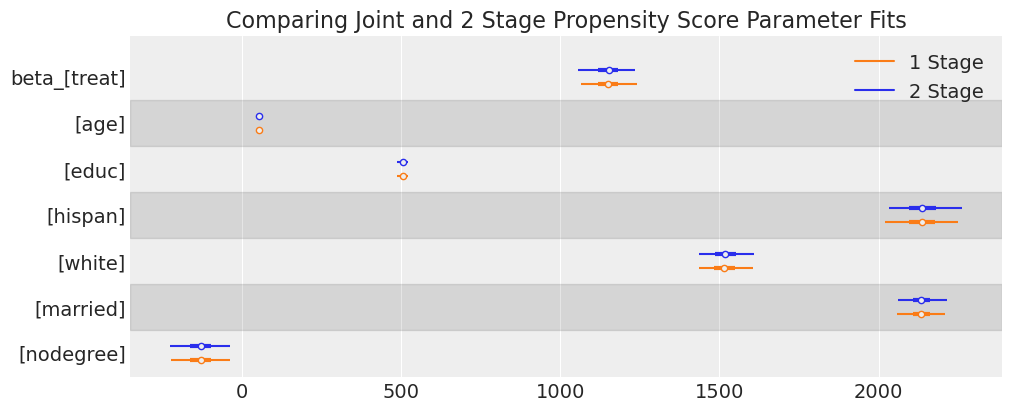

In [419]:
ax = az.plot_forest(
    [idata_outcome_2s_lalonde, idata_lalonde],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

In [416]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_lalonde, var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_lalonde, var_names=["beta_", "alpha_outcome"]
        ),
    }
)
compare_estimate

mean       sd    hdi_3%   hdi_97%  \
1-stage-model alpha_trt          -1.355    0.139    -1.605    -1.091   
              beta_[treat]     1149.719   47.432  1065.331  1242.215   
              beta_[age]         53.667    1.922    50.150    57.373   
              beta_[educ]       505.114    9.162   487.609   522.057   
              beta_[hispan]    2135.908   61.219  2018.786  2249.659   
              beta_[white]     1516.877   46.940  1434.939  1606.563   
              beta_[married]   2134.419   40.375  2057.024  2207.299   
              beta_[nodegree]  -130.674   49.781  -224.402   -38.994   
              beta_ps             0.044    1.001    -1.934     1.807   
              alpha_outcome   -1997.598  142.574 -2257.739 -1732.050   
2-stage-model beta_[treat]     1150.944   47.697  1054.922  1234.678   
              beta_[age]         53.679    1.943    49.861    57.123   
              beta_[educ]       505.201    9.355   487.661   522.066   
              beta_[hispan]    2136.087   61.713  2032.252  2262.126   
              beta_[white]     1518.493   46.967  1437.026  1609.413   
              beta_[married]   2134.947   41.064  2059.841  2215.577   
              beta_[nodegree]  -130.579   50.495  -226.073   -36.906   
              alpha_outcome   -2000.090  144.644 -2259.261 -1721.027   

                               mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat  
1-stage-model alpha_trt            0.002    0.002    3330.0    2698.0    1.0  
              beta_[treat]         0.860    0.608    3040.0    3062.0    1.0  
              beta_[age]           0.033    0.024    3329.0    2843.0    1.0  
              beta_[educ]          0.214    0.151    1840.0    2486.0    1.0  
              beta_[hispan]        1.063    0.752    3308.0    3127.0    1.0  
              beta_[white]         0.894    0.632    2753.0    2722.0    1.0  
              beta_[married]       0.703    0.497    3310.0    2565.0    1.0  
              beta_[nodegree]      1.108    0.792    2021.0    2664.0    1.0  
              beta_ps              0.015    0.016    4589.0    2672.0    1.0  
              alpha_outcome        3.485    2.465    1674.0    2349.0    1.0  
2-stage-model beta_[treat]         0.701    0.496    4614.0    3288.0    1.0  
              beta_[age]           0.028    0.020    4690.0    2976.0    1.0  
              beta_[educ]          0.191    0.135    2411.0    2964.0    1.0  
              beta_[hispan]        0.892    0.631    4827.0    2604.0    1.0  
              beta_[white]         0.739    0.523    4050.0    2945.0    1.0  
              beta_[married]       0.508    0.359    6524.0    2973.0    1.0  
              beta_[nodegree]      0.975    0.689    2686.0    2933.0    1.0  
              alpha_outcome        3.081    2.182    2206.0    2622.0    1.0

Both estimates of the treatment effects accord well with values in the literature. We can be happy that both models are picking up on the structure of the conditional treatment effect well. 

## NHEFS 

Finally we turn to the NHEFS data. This data is known to be have a complex covariate profile for measuring aspects smokers health. We might suspect that there is some unmeasured confounding in this data set that would be hard to pick up on with simple regression controls. 

In [420]:
df = cp.load_data("nhefs")
df[["age", "race", "trt", "smokeintensity", "smokeyrs", "outcome"]].head()

,age,race,trt,smokeintensity,smokeyrs,outcome
0,42,1,0,30,29,-10.093960
1,36,0,0,20,24,2.604970
2,56,1,0,20,26,9.414486
3,68,1,0,3,53,4.990117
4,40,0,0,20,19,4.989251


In [421]:
coords = {
    "betas": [
        "trt",
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ],
    "betas_trt": [
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ],
    "obs": range(df.shape[0]),
}

N = df.shape[0]
X_trt = df[
    [
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ]
]
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)
X_outcome = df[
    [
        "trt",
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ]
]
X_outcome = (X_outcome - X_outcome.mean(axis=0)) / X_outcome.std(axis=0)
T_data = df["trt"].values
X_outcome["trt"] = T_data
Y_data = df["outcome"].values

nhefs_model = make_model(X_trt, X_outcome, T_data, Y_data, coords)
with nhefs_model:
    idata_nhefs = pm.sample()


(
    idata_treatment_2s_nhefs,
    idata_outcome_2s_nhefs,
    treatment_model_nhefs,
    outcome_model_nhefs,
) = make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps_spline, beta_ps, alpha_trt, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 10 seconds.
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/site-packages/pymc/data.py:436: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Sampling: [alpha_outcome, beta_ps_spline, beta_std, like, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps_spline, alpha_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

/Users/nathanielforde/mambaforge/envs/bayesian_causal_book/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


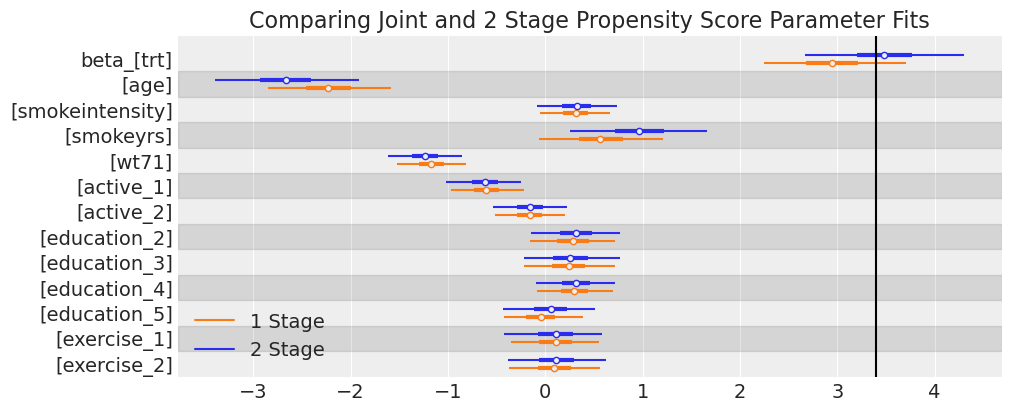

In [424]:
ax = az.plot_forest(
    [idata_outcome_2s_nhefs, idata_nhefs],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].axvline(3.4, label="True Treatment Value", color="k")
ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

Here we see the model specifications start to come apart. 

In [423]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_nhefs, var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_nhefs, var_names=["beta_", "alpha_outcome"]
        ),
    }
)
compare_estimate

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1-stage-model alpha_trt             -1.118  0.061  -1.230   -0.999      0.001   
              beta_[trt]             2.945  0.390   2.243    3.702      0.005   
              beta_[age]            -2.232  0.344  -2.853   -1.581      0.005   
              beta_[smokeintensity]  0.313  0.194  -0.058    0.664      0.002   
              beta_[smokeyrs]        0.572  0.345  -0.066    1.209      0.005   
              beta_[wt71]           -1.172  0.189  -1.524   -0.815      0.002   
              beta_[active_1]       -0.605  0.196  -0.964   -0.220      0.002   
              beta_[active_2]       -0.160  0.190  -0.512    0.203      0.002   
              beta_[education_2]     0.285  0.236  -0.158    0.716      0.003   
              beta_[education_3]     0.246  0.249  -0.215    0.714      0.003   
              beta_[education_4]     0.301  0.208  -0.081    0.697      0.003   
              beta_[education_5]    -0.047  0.218  -0.427    0.387      0.003   
              beta_[exercise_1]      0.108  0.244  -0.348    0.551      0.003   
              beta_[exercise_2]      0.094  0.248  -0.371    0.563      0.003   
              beta_ps               -0.045  0.951  -1.810    1.729      0.013   
              alpha_outcome          1.830  0.313   1.235    2.410      0.004   
2-stage-model beta_[trt]             3.488  0.432   2.666    4.304      0.006   
              beta_[age]            -2.670  0.387  -3.391   -1.919      0.006   
              beta_[smokeintensity]  0.321  0.221  -0.087    0.735      0.003   
              beta_[smokeyrs]        0.966  0.377   0.259    1.662      0.006   
              beta_[wt71]           -1.234  0.199  -1.617   -0.859      0.003   
              beta_[active_1]       -0.618  0.206  -1.018   -0.246      0.003   
              beta_[active_2]       -0.157  0.203  -0.532    0.222      0.003   
              beta_[education_2]     0.319  0.245  -0.147    0.766      0.004   
              beta_[education_3]     0.257  0.267  -0.220    0.768      0.004   
              beta_[education_4]     0.319  0.217  -0.096    0.714      0.003   
              beta_[education_5]     0.054  0.255  -0.430    0.515      0.004   
              beta_[exercise_1]      0.109  0.264  -0.420    0.580      0.004   
              beta_[exercise_2]      0.116  0.269  -0.383    0.625      0.004   
              alpha_outcome          1.577  0.354   0.958    2.302      0.006   

                                     mcse_sd  ess_bulk  ess_tail  r_hat  
1-stage-model alpha_trt                0.000    7704.0    2887.0    1.0  
              beta_[trt]               0.003    7047.0    2953.0    1.0  
              beta_[age]               0.003    5378.0    2602.0    1.0  
              beta_[smokeintensity]    0.002    7233.0    3615.0    1.0  
              beta_[smokeyrs]          0.004    5823.0    2955.0    1.0  
              beta_[wt71]              0.002    6733.0    3029.0    1.0  
              beta_[active_1]          0.002    6707.0    3428.0    1.0  
              beta_[active_2]          0.002    6797.0    2967.0    1.0  
              beta_[education_2]       0.003    5452.0    3438.0    1.0  
              beta_[education_3]       0.003    5324.0    3589.0    1.0  
              beta_[education_4]       0.002    5151.0    3304.0    1.0  
              beta_[education_5]       0.003    5217.0    3415.0    1.0  
              beta_[exercise_1]        0.003    5949.0    3507.0    1.0  
              beta_[exercise_2]        0.003    6351.0    3078.0    1.0  
              beta_ps                  0.014    5375.0    3389.0    1.0  
              alpha_outcome            0.003    5564.0    3178.0    1.0  
2-stage-model beta_[trt]               0.004    5879.0    2724.0    1.0  
              beta_[age]               0.004    4912.0    2815.0    1.0  
              beta_[smokeintensity]    0.002    4486.0    2935.0    1.0  
              beta_[smokeyrs]          0.004  

### The Problem of Feedback

The issue here is sometimes called Bayesian feedback or "collider bias via the likelihood", and it's a key issue when trying to build joint models for causal inference in the Bayesian paradigm. Because we fit the outcome and the treatment models simultaneously, and this means that the outcome can influence the posterior distribution of the parameters $\beta$ in the treatment model and it violates the idea of design-before-analysis. We have here an apparent example of a slight bias due to this effect. The two stage modular approach seems to better recover the treatment effect reported in the literature and avoids the risk of collider bias. 
